In [24]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
### Data:

# --------------------------------------------------------
path_dict = {"dk_l1": "Data/DanishL1",
             "dk_weighted": "Data/DanishWeighted",
             "dk_l1weighted": "Data/DanishL1Weighted",
             }

# --------------------------------------------------------

cm_dict = {key : json.load(open(f"{value}/CMS_final{key.split('_')[-1].capitalize()}.json")) for key, value in path_dict.items()}

mc_dict = {key : pd.read_csv(f"{value}/MC_final{key.split('_')[-1].capitalize()}.csv") for key, value in path_dict.items()}

In [22]:
def plot_cm(c_matrix, title="Confusion Matrix"):
    # Class labels
    class_names = ["None", "Minimal", "Basic", "Good", "Excellent"]
    
    # Convert to numpy array if needed
    cm = np.array(c_matrix)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [17]:
### Metric Functions
def tp(multi_class_confusion_matrix):
    return np.diag(multi_class_confusion_matrix)

def fp(multi_class_confusion_matrix):
    return np.sum(multi_class_confusion_matrix, axis=0) - tp(multi_class_confusion_matrix)

def fn(multi_class_confusion_matrix):
    return np.sum(multi_class_confusion_matrix, axis=1) - tp(multi_class_confusion_matrix)

def tn(multi_class_confusion_matrix):
    total = np.sum(multi_class_confusion_matrix)
    return total - (tp(multi_class_confusion_matrix) + fp(multi_class_confusion_matrix) + fn(multi_class_confusion_matrix))

def precision(tp,fp):
    return tp / (tp + fp) if (tp + fp).all() else np.nan

def recall(tp,fn):
    return tp / (tp + fn) if (tp + fn).all() else np.nan

def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall).all() else np.nan

def cm_metrics(cm):
    tp_values = tp(cm)
    fp_values = fp(cm)
    fn_values = fn(cm)
    tn_values = tn(cm)

    class_metrics = {}

    for i in range(len(cm)):
        precision_values = precision(tp_values[i], fp_values[i])
        recall_values = recall(tp_values[i], fn_values[i])
        f1_values = f1_score(precision_values, recall_values)

        class_metrics[i] = {
            "TP": tp_values[i],
            "FP": fp_values[i],
            "FN": fn_values[i],
            "TN": tn_values[i],
            "Precision": precision_values,
            "Recall": recall_values,
            "F1 Score": f1_values
        }

    return class_metrics

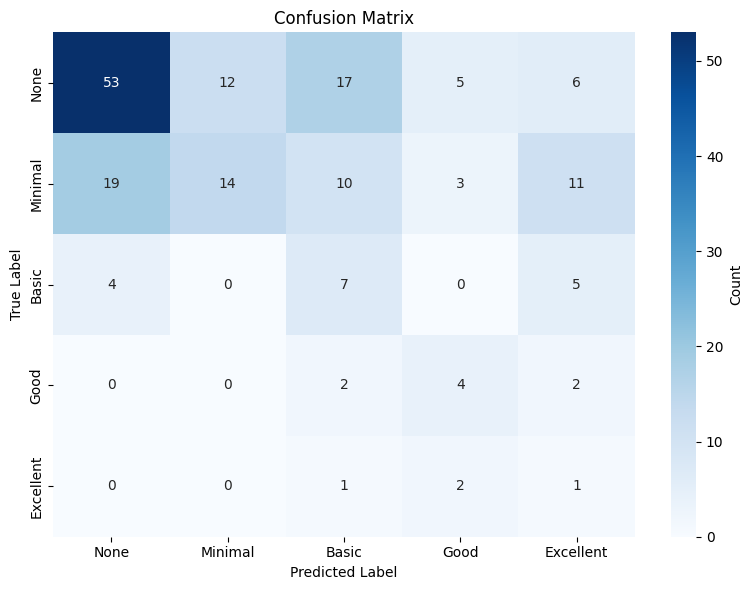

In [35]:
plot_cm(cm_dict["dk_l1weighted"]["epoch_10"])

In [20]:
cm_metrics(cm_dict["dk_l1"]["epoch_100"])

{0: {'TP': np.float64(76.0),
  'FP': np.float64(26.0),
  'FN': np.float64(17.0),
  'TN': np.float64(59.0),
  'Precision': np.float64(0.7450980392156863),
  'Recall': np.float64(0.8172043010752689),
  'F1 Score': np.float64(0.7794871794871795)},
 1: {'TP': np.float64(35.0),
  'FP': np.float64(28.0),
  'FN': np.float64(22.0),
  'TN': np.float64(93.0),
  'Precision': np.float64(0.5555555555555556),
  'Recall': np.float64(0.6140350877192983),
  'F1 Score': np.float64(0.5833333333333335)},
 2: {'TP': np.float64(5.0),
  'FP': np.float64(4.0),
  'FN': np.float64(11.0),
  'TN': np.float64(158.0),
  'Precision': np.float64(0.5555555555555556),
  'Recall': np.float64(0.3125),
  'F1 Score': np.float64(0.39999999999999997)},
 3: {'TP': np.float64(2.0),
  'FP': np.float64(2.0),
  'FN': np.float64(6.0),
  'TN': np.float64(168.0),
  'Precision': np.float64(0.5),
  'Recall': np.float64(0.25),
  'F1 Score': np.float64(0.3333333333333333)},
 4: {'TP': np.float64(0.0),
  'FP': np.float64(0.0),
  'FN': np